In [13]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(stringr))
library(parallel)
library(reshape2)
library(ggalluvial)

library(rstatix)
library(ggpubr)
library(ggplot2) 
source('/home//jupyter/BRI_Figures_Final_V2//helper_function/helper_function_IHA.r')

# Read Interaction Scores

In [14]:
meta_data=read.csv("/home/jupyter/BRI_Figures_Final_V2/Dataset/scRNA_meta_data-2024-05-09.csv")
df<-read.csv('/home/jupyter/BRI_Figures_Final_V2/Figure6/03_CellPhoneDB/combined_statistical_analysis_significant_means.csv',check.names = FALSE)

In [15]:
df<-pivot_longer(
  df,
  cols = matches("\\|"), # Select columns with pattern "|"
  names_to = c("variable"),
  values_to = "mean_interaction"
)

In [16]:
df<-df[!is.na(df$mean_interaction),]

In [17]:
df<-left_join(df,meta_data) %>% 
filter(sample.visitName %in% c("Flu Year 2 Day 0"))

Joining with `by = join_by(pbmc_sample_id)`


In [18]:
selected_pairs<-c('CD40LG_CD40','PTPRC_CD22','SEMA4D_CD72','CD86_CD28','APP_CD74')
df<- df %>% filter(variable%in% c('CM CD4 T cell|Core memory B cell',
                                                                                         'Core memory B cell|CM CD4 T cell'))%>% 
filter(interacting_pair %in% selected_pairs)

# Group Comparison

In [19]:
stat<-df %>% group_by(sample.visitName,interacting_pair) %>% wilcox_test(mean_interaction~cohort.cohortGuid)

In [20]:
stat$p<-round(stat$p,4)

In [21]:
stat

interacting_pair,sample.visitName,.y.,group1,group2,n1,n2,statistic,p
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>
APP_CD74,Flu Year 2 Day 0,mean_interaction,BR1,BR2,37,37,805.0,0.1940
CD40LG_CD40,Flu Year 2 Day 0,mean_interaction,BR1,BR2,40,44,1183.5,0.0066
CD86_CD28,Flu Year 2 Day 0,mean_interaction,BR1,BR2,34,39,881.5,0.0159
PTPRC_CD22,Flu Year 2 Day 0,mean_interaction,BR1,BR2,40,44,1185.5,0.0063
SEMA4D_CD72,Flu Year 2 Day 0,mean_interaction,BR1,BR2,37,39,922.5,0.0372


# Plotting

In [22]:
df_plotting<-df  %>% group_by(interacting_pair,variable) %>% 
mutate(scaled_interaction_score=scale(mean_interaction)) %>% group_by(interacting_pair,variable,sample.visitName,cohort.cohortGuid)%>% summarise(median_interation_score=median(scaled_interaction_score))

`summarise()` has grouped output by 'interacting_pair', 'variable',
'sample.visitName'. You can override using the `.groups` argument.


In [23]:
df_plotting$T_cell<-result <- sapply(strsplit(df_plotting$interacting_pair, "_"), `[`, 1)
df_plotting$B_cell<-result <- sapply(strsplit(df_plotting$interacting_pair, "_"), `[`, 2)
df_plotting$T_cell<-factor(df_plotting$T_cell,levels=unique(df_plotting$T_cell))
df_plotting$B_cell<-factor(df_plotting$B_cell,levels=unique(df_plotting$B_cell))

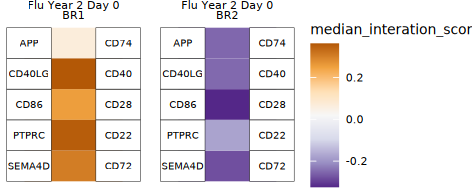

In [24]:
options(repr.plot.width = 100/25.4, repr.plot.height =  40/25.4)

p<-ggplot(data = df_plotting %>% arrange(T_cell,B_cell,median_interation_score),
       aes(axis1 = T_cell, axis2 = B_cell)) +
  geom_alluvium(aes(fill = median_interation_score),size=1,width=0.1,
                alpha = 1, decreasing = FALSE, curve_type = "sigmoid",
                knot.pos = 1, knot.prop = FALSE
)+
  scale_fill_distiller(palette = "PuOr")  +
  geom_stratum(size=0.1, width = 0.5) +
  geom_text(stat = "stratum",size=2 ,
            aes(label = after_stat(stratum))) +
  theme_void(base_size=8)+facet_wrap(~sample.visitName+
                                     cohort.cohortGuid,
                                     ncol=4)
p
ggsave("FigureC.pdf",p, width=100/25.4,height = 40/25.4)